# making dataset ready

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
!pip install wordcloud


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from contractions import contractions_dict
import contractions
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

## downloading the dataset

In [ ]:
# (github) URL of the CSV file
url = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(url, index_col=0)

# Display the first few rows of the DataFrame
df.head()


,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## EDA

In [ ]:
# Basic information about the DataFrame
  df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [ ]:
# Summary statistics of the DataFrame
df.describe()


,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


In [ ]:
# Check for missing values
print(df.isnull().sum())


count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64


<ipython-input-8-5534a1775af6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette='viridis')


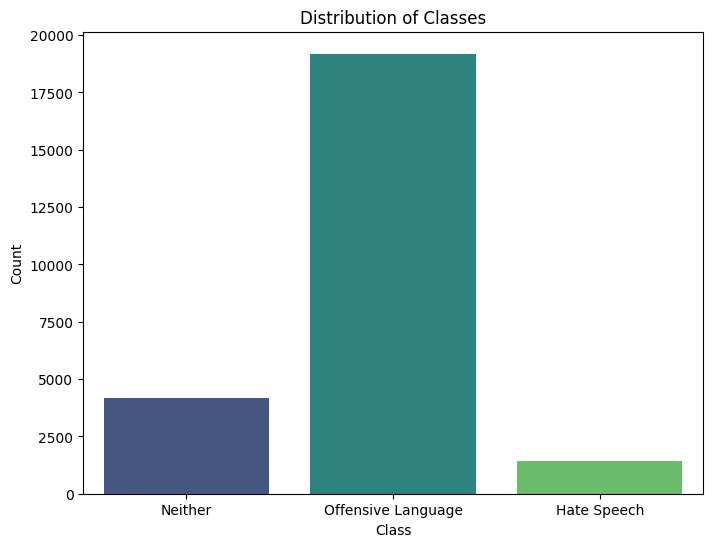

class
Offensive Language    77.432111
Neither               16.797805
Hate Speech            5.770084
Name: proportion, dtype: float64


In [ ]:
# Rename the class labels for better readability
class_labels = {0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}
df['class'] = df['class'].map(class_labels)

# Distribution of 'class' column
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df, palette='viridis')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Display the class distribution as a percentage
class_distribution = df['class'].value_counts(normalize=True) * 100
print(class_distribution)


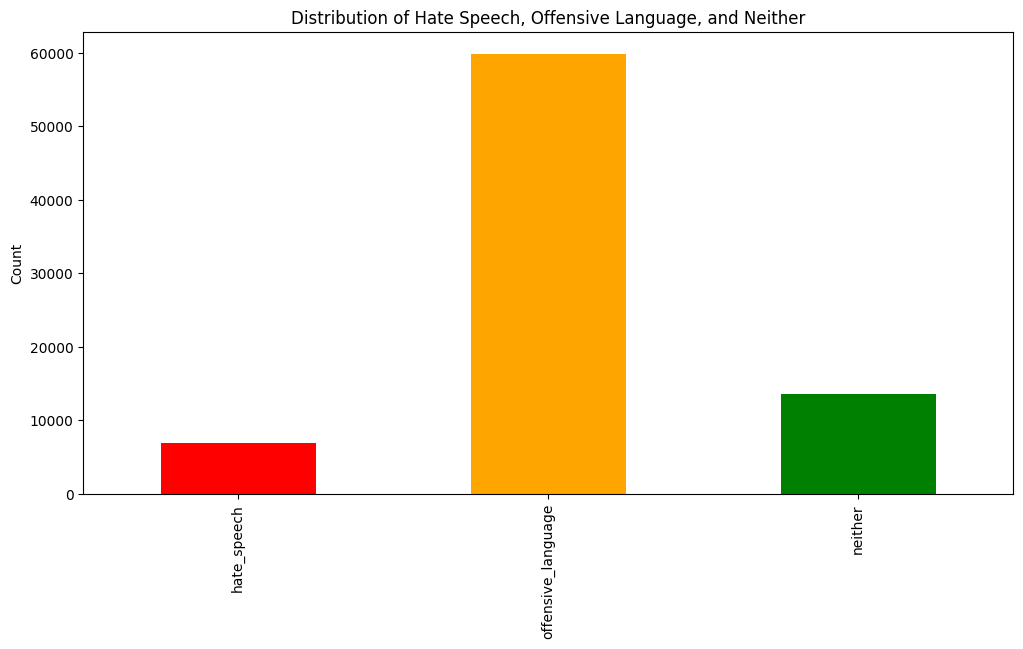

In [ ]:
# Distribution of hate_speech, offensive_language, and neither
plt.figure(figsize=(12, 6))
df[['hate_speech', 'offensive_language', 'neither']].sum().plot(kind='bar', color=['red', 'orange', 'green'])
plt.title('Distribution of Hate Speech, Offensive Language, and Neither')
plt.ylabel('Count')
plt.show()


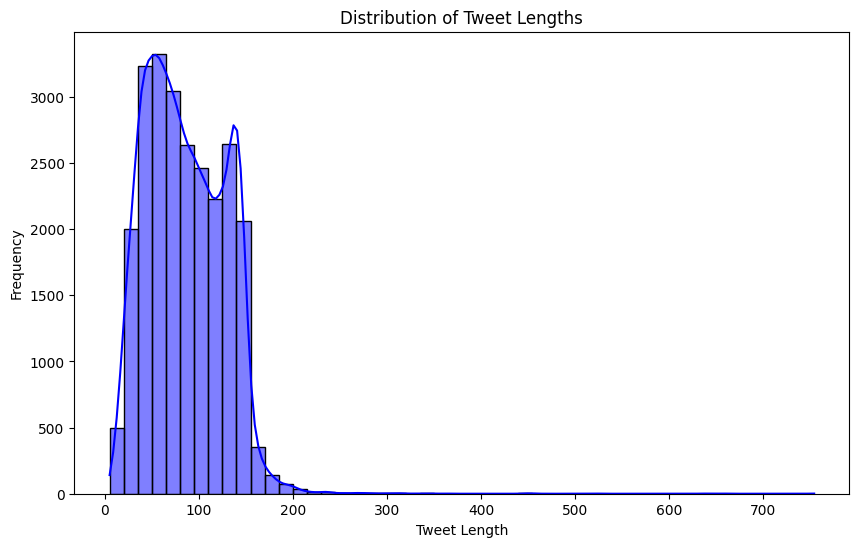

In [ ]:
# Add a new column for the length of each tweet
df['tweet_length'] = df['tweet'].apply(len)

# Distribution of tweet lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


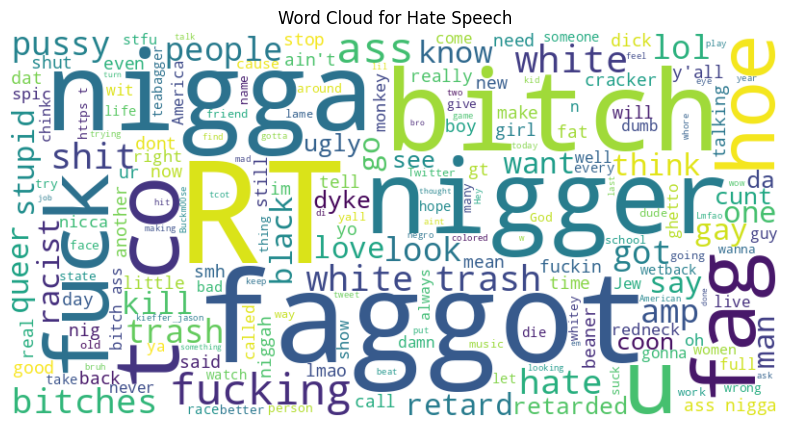

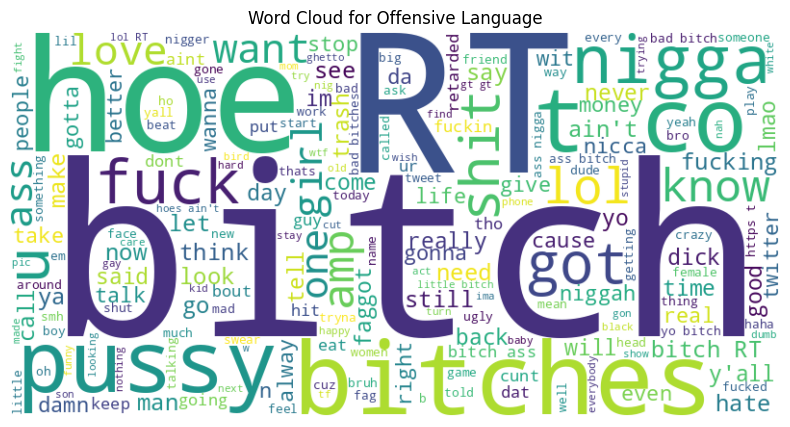

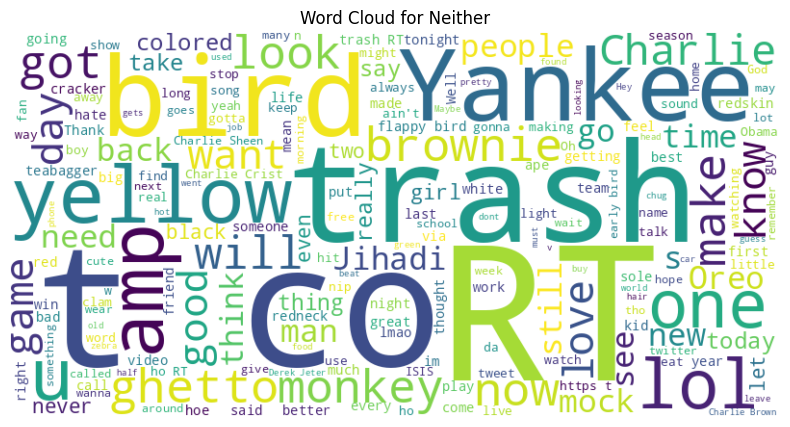

In [ ]:
# Generate word cloud for each class
for class_label, class_name in class_labels.items():
    text = ' '.join(df[df['class'] == class_name]['tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {class_name}')
    plt.axis('off')
    plt.show()


<ipython-input-12-4cc66e1f2def>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='tweet_length', data=df, palette='viridis')


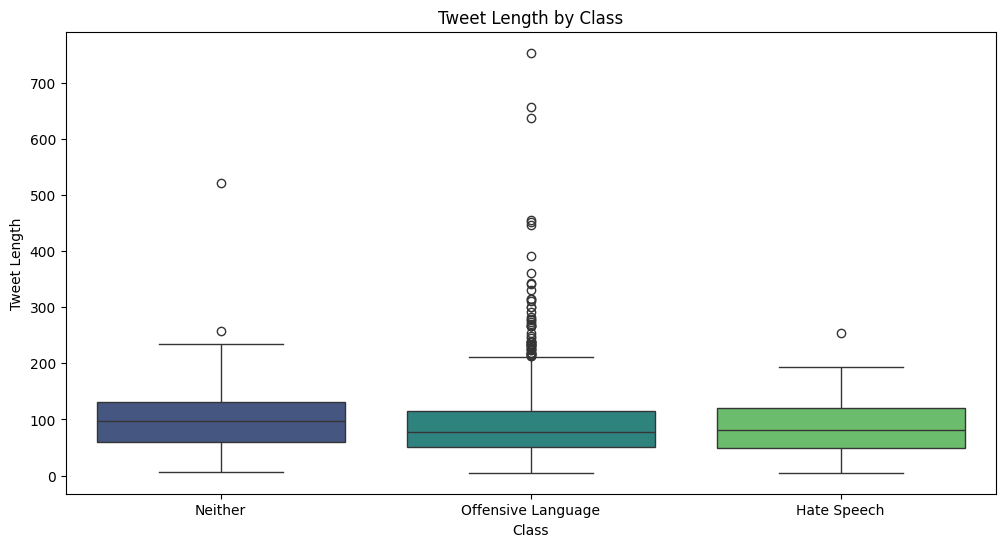

In [ ]:
# Box plot of tweet length by class
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='tweet_length', data=df, palette='viridis')
plt.title('Tweet Length by Class')
plt.xlabel('Class')
plt.ylabel('Tweet Length')
plt.show()


In [ ]:
for class_label, class_name in class_labels.items():
    text = ' '.join(df[df['class'] == class_name]['tweet'])
    word_counts = Counter(text.split())
    most_common_words = word_counts.most_common(10)
    print(f'Most Common Words in {class_name} Tweets:')
    for word, count in most_common_words:
        print(f'{word}: {count}')
    print('\n')


Most Common Words in Hate Speech Tweets:
a: 530
the: 349
you: 348
to: 320
RT: 320
I: 296
and: 219
is: 194
bitch: 164
that: 161


Most Common Words in Offensive Language Tweets:
a: 7301
bitch: 6464
RT: 5912
I: 5252
the: 4545
you: 4092
to: 3926
and: 2639
my: 2599
that: 2588


Most Common Words in Neither Tweets:
the: 1696
RT: 1307
a: 1268
to: 994
I: 924
and: 812
in: 687
of: 671
is: 634
trash: 524




In [ ]:
df

,count,hate_speech,offensive_language,neither,class,tweet,tweet_length
0,3,0,0,3,Neither,!!! RT @mayasolovely: As a woman you shouldn't...,140
1,3,0,3,0,Offensive Language,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,85
2,3,0,3,0,Offensive Language,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,120
3,3,0,2,1,Offensive Language,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,62
4,6,0,6,0,Offensive Language,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137
...,...,...,...,...,...,...,...
25291,3,0,2,1,Offensive Language,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,146
25292,3,0,1,2,Neither,"you've gone and broke the wrong heart baby, an...",70
25294,3,0,3,0,Offensive Language,young buck wanna eat!!.. dat nigguh like I ain...,67
25295,6,0,6,0,Offensive Language,youu got wild bitches tellin you lies,37


In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to clean each tweet
def clean_tweet(tweet):
    # Remove the "RT" symbol
    tweet = re.sub(r'\bRT\b', '', tweet)

    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

    # Remove special characters, numbers, punctuations
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)

    # Convert HTML entities
    tweet = BeautifulSoup(tweet, 'html.parser').get_text()

    # Convert to lowercase
    tweet = tweet.lower()

    # Expand contractions
    for contraction, expanded in contractions_dict.items():
        tweet = tweet.replace(contraction, expanded)

    # Tokenize tweet
    tweet_tokens = word_tokenize(tweet)

    # Remove stopwords
    tweet_tokens_wo_stop_words = [word for word in tweet_tokens if word not in stop_words]

    # Lemmatize tokens
    tweet_tokens_lemmatized = [lemmatizer.lemmatize(word) for word in tweet_tokens_wo_stop_words]

    # Join tokens back to string
    cleaned_tweet = ' '.join(tweet_tokens)
    preprocessed_tweet=' '.join(tweet_tokens_lemmatized)
    return cleaned_tweet,preprocessed_tweet

# Apply cleaning function to each tweet and expand the results into two columns
df[['cleaned_tweet', 'preprocessed_tweet']] = df['tweet'].apply(clean_tweet).apply(pd.Series)

# Display the DataFrame with cleaned tweets
df[['tweet', 'cleaned_tweet', 'preprocessed_tweet']]



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,tweet,cleaned_tweet,preprocessed_tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about cleanin...,woman shouldnt complain cleaning house amp man...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat hoe i...,boy dat coldtyga dwn bad cuffin dat hoe st place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she start to cr...,dawg ever fuck bitch start cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like a tranny,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,the shit you hear about me might be true or it...,shit hear might true might faker bitch told ya
...,...,...,...
25291,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,yous a muthafin lie right his tl is trash now ...,yous muthafin lie right tl trash mine bible sc...
25292,"you've gone and broke the wrong heart baby, an...",youve gone and broke the wrong heart baby and ...,youve gone broke wrong heart baby drove rednec...
25294,young buck wanna eat!!.. dat nigguh like I ain...,young buck want to eat dat nigguh like i aint ...,young buck want eat dat nigguh like aint fucki...
25295,youu got wild bitches tellin you lies,youu got wild bitches tellin you lies,youu got wild bitch tellin lie


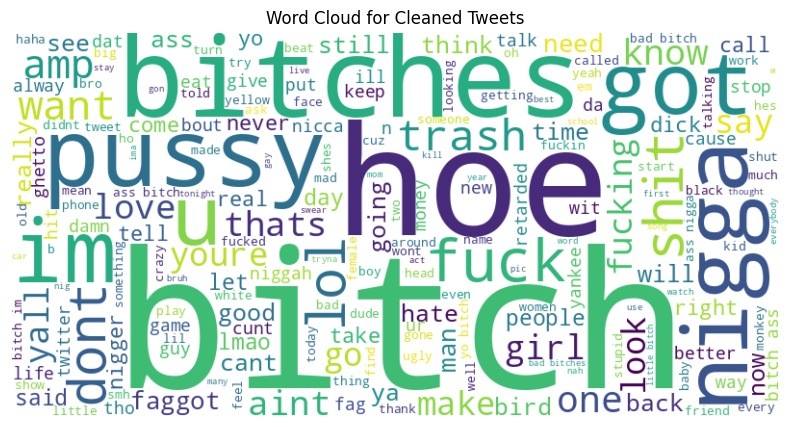

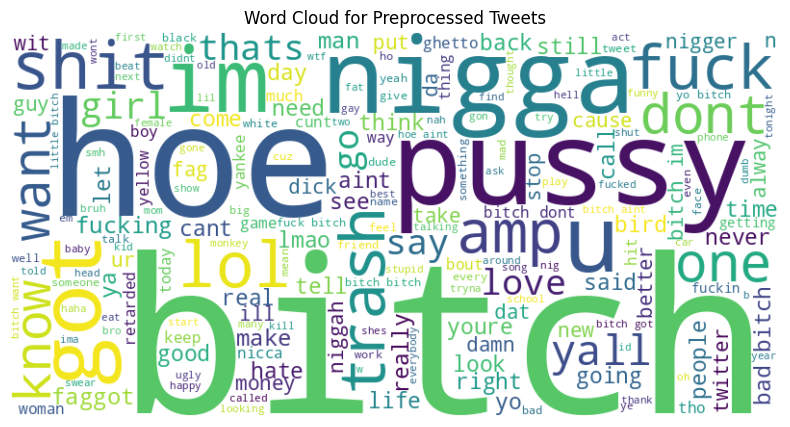

In [ ]:
# Function to generate a word cloud from text
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Combine all text from the 'cleaned_tweet' column into one string
cleaned_text = ' '.join(df['cleaned_tweet'])

# Combine all text from the 'preprocessed_tweet' column into one string
preprocessed_text = ' '.join(df['preprocessed_tweet'])

# Generate word cloud for cleaned tweets
generate_word_cloud(cleaned_text, 'Word Cloud for Cleaned Tweets')

# Generate word cloud for preprocessed tweets
generate_word_cloud(preprocessed_text, 'Word Cloud for Preprocessed Tweets')

In [ ]:
# Function to count word frequencies
def count_word_frequencies(text):
    # Split text into words
    words = text.split()
    # Use Counter to count word frequencies
    word_counts = Counter(words)
    return word_counts

# Combine all text from the 'cleaned_tweet' column into one string
cleaned_text = ' '.join(df['cleaned_tweet'])

# Combine all text from the 'preprocessed_tweet' column into one string
preprocessed_text = ' '.join(df['preprocessed_tweet'])

# Count word frequencies for cleaned tweets
cleaned_word_counts = count_word_frequencies(cleaned_text)

# Count word frequencies for preprocessed tweets
preprocessed_word_counts = count_word_frequencies(preprocessed_text)

# Display the 10 most common words in cleaned tweets
print("10 Most Common Words in Cleaned Tweets:")
print(cleaned_word_counts.most_common(10))

# Display the 10 most common words in preprocessed tweets
print("\n10 Most Common Words in Preprocessed Tweets:")
print(preprocessed_word_counts.most_common(10))

10 Most Common Words in Cleaned Tweets:
[('a', 9498), ('bitch', 8237), ('i', 7531), ('the', 7177), ('to', 6346), ('you', 6112), ('and', 3958), ('my', 3582), ('that', 3527), ('bitches', 3084)]

10 Most Common Words in Preprocessed Tweets:
[('bitch', 11326), ('hoe', 4279), ('like', 2819), ('pussy', 2216), ('im', 2090), ('nigga', 1992), ('dont', 1781), ('got', 1601), ('as', 1570), ('get', 1536)]


In [ ]:
# Rename the class labels for better readability
class_labels = { 'Hate Speech':0, 'Offensive Language':1, 'Neither':2}
df['label'] = df['class'].map(class_labels)


In [ ]:
# Split the data into train (70%) and temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Split the temp data into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Save the dataframes to CSV files
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)
temp_df.to_csv('val+test.csv', index=False)
print("Dataframes saved as train.csv, val.csv, and test.csv")


Dataframes saved as train.csv, val.csv, and test.csv


Class distribution in train set:
class
Offensive Language    77.490201
Neither               16.728153
Hate Speech            5.781646
Name: proportion, dtype: float64


Class distribution in validation set:
class
Offensive Language    77.132096
Neither               16.949153
Hate Speech            5.918752
Name: proportion, dtype: float64


Class distribution in test set:
class
Offensive Language    77.461001
Neither               16.971490
Hate Speech            5.567509
Name: proportion, dtype: float64


Class distribution in total set:
class
Offensive Language    77.432111
Neither               16.797805
Hate Speech            5.770084
Name: proportion, dtype: float64




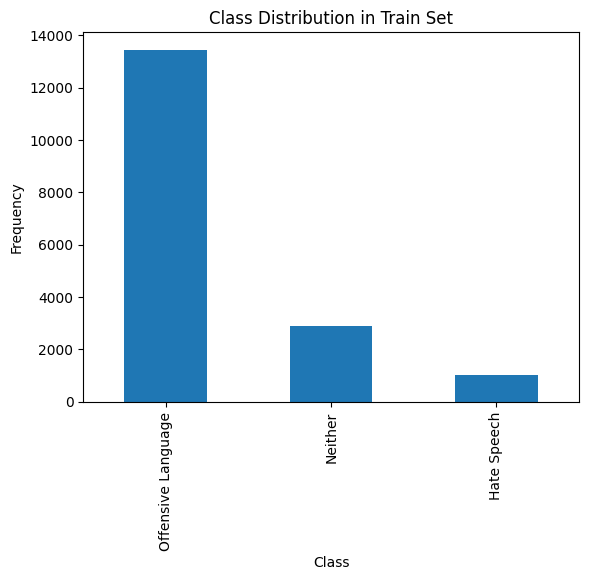

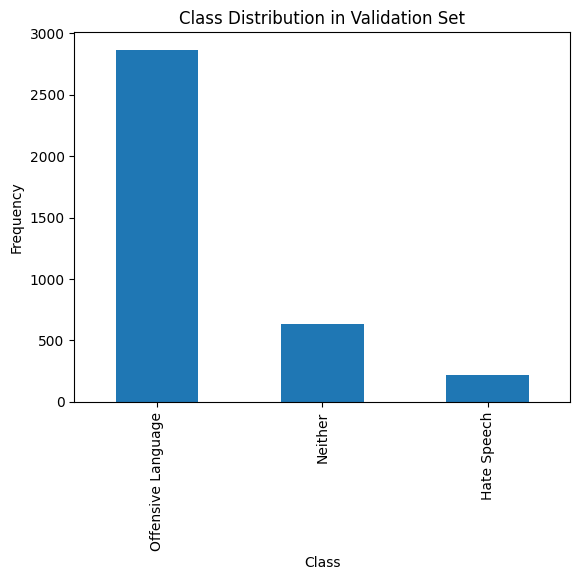

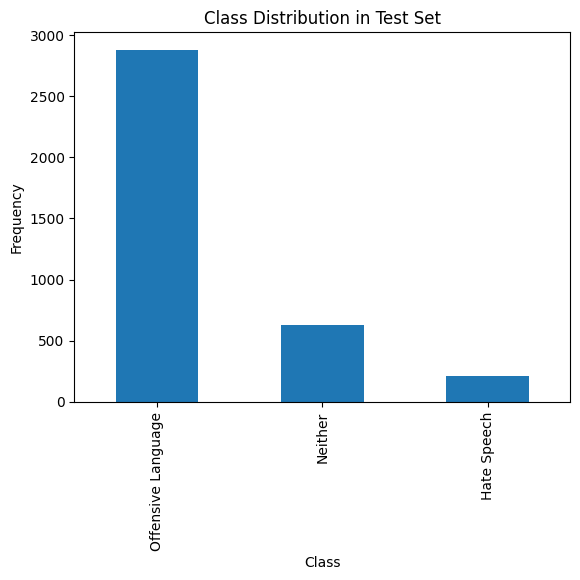

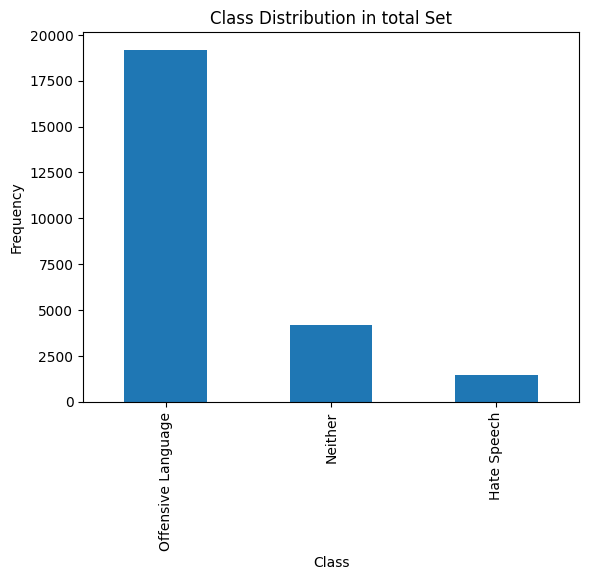

In [ ]:
# Function to print class distribution
def print_class_distribution(df, dataset_name):
    class_counts = df['class'].value_counts(normalize=True) * 100
    print(f"Class distribution in {dataset_name} set:")
    print(class_counts)
    print("\n")

# Check class distribution
print_class_distribution(train_df, "train")
print_class_distribution(val_df, "validation")
print_class_distribution(test_df, "test")
print_class_distribution(df, "total")

# Function to plot class distribution
def plot_class_distribution(df, dataset_name):
    class_counts = df['class'].value_counts()
    class_counts.plot(kind='bar')
    plt.title(f"Class Distribution in {dataset_name} Set")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

# Plot class distributions
plot_class_distribution(train_df, "Train")
plot_class_distribution(val_df, "Validation")
plot_class_distribution(test_df, "Test")
plot_class_distribution(df, "total")


In [ ]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,tweet_length,cleaned_tweet,preprocessed_tweet,label
0,3,0,0,3,Neither,!!! RT @mayasolovely: As a woman you shouldn't...,140,as a woman you shouldnt complain about cleanin...,woman shouldnt complain cleaning house amp man...,2
1,3,0,3,0,Offensive Language,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,85,boy dats coldtyga dwn bad for cuffin dat hoe i...,boy dat coldtyga dwn bad cuffin dat hoe st place,1
2,3,0,3,0,Offensive Language,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,120,dawg you ever fuck a bitch and she start to cr...,dawg ever fuck bitch start cry confused shit,1
3,3,0,2,1,Offensive Language,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,62,she look like a tranny,look like tranny,1
4,6,0,6,0,Offensive Language,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137,the shit you hear about me might be true or it...,shit hear might true might faker bitch told ya,1


# nlp models

In [ ]:
# Load Data
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")


In [ ]:
# Inspect the data
print(train_df['cleaned_tweet'].head())
print(val_df['cleaned_tweet'].head())
print(test_df['cleaned_tweet'].head())

# Check for missing values
print(train_df['cleaned_tweet'].isnull().sum())
print(val_df['cleaned_tweet'].isnull().sum())
print(test_df['cleaned_tweet'].isnull().sum())

# Drop rows with missing values in 'cleaned_tweet'
train_df = train_df.dropna(subset=['cleaned_tweet'])
val_df = val_df.dropna(subset=['cleaned_tweet'])
test_df = test_df.dropna(subset=['cleaned_tweet'])

0    charlie jacobs got confused about the ice buck...
1    she playin pussy hole bingo she drawing the ne...
2    i be telling mcgirt music aint enoughyou got t...
3    i aint to show bout dem colored diamonds you t...
4    yall claim you want a good amp loyal girl but ...
Name: cleaned_tweet, dtype: object
0                       hoe about to bust ha knee caps
1    i know i talk a lot of shit but bitch best bel...
2                   all people do in my house is bitch
3                       i got my eyes on this red bone
4    i gota hand fulla brothers trek gang bitch we ...
Name: cleaned_tweet, dtype: object
0    confusing circumstances seem to get in the way...
1    psa big booty hoe with tig ol bitties xbox one...
2    maybe i shoulda informed my cousin of my socia...
3    why the fuck are the throwing batting practice...
4                     you just want some attention hoe
Name: cleaned_tweet, dtype: object
1
0
1


## bert

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
1085/1085 [==============================] - 323s 270ms/step - loss: 0.6063 - accuracy: 0.7831 - val_loss: 0.5839 - val_accuracy: 0.7920
Epoch 2/10
1085/1085 [==============================] - 281s 259ms/step - loss: 0.5486 - accuracy: 0.8010 - val_loss: 0.5151 - val_accuracy: 0.8152
Epoch 3/10
1085/1085 [==============================] - 282s 259ms/step - loss: 0.5350 - accuracy: 0.8053 - val_loss: 0.4990 - val_accuracy: 0.8227
Epoch 4/10
1085/1085 [==============================] - 274s 252ms/step - loss: 0.5282 - accuracy: 0.8068 - val_loss: 0.5113 - val_accuracy: 0.8095
Epoch 5/10
1085/1085 [==============================] - 286s 264ms/step - loss: 0.5258 - accuracy: 0.8063 - val_loss: 0.4781 - val_accuracy: 0.8284
Epoch 6/10
1085/1085 [==============================] - 310s 285ms/step - loss: 0.5190 - accuracy: 0.8113 - val_loss: 0.4866 - val_accuracy: 0.8171
Epoch 7/10
1085/1085 [==============================] - 274s 253ms/step - loss: 0.5177 - accuracy: 0.8108 - val_

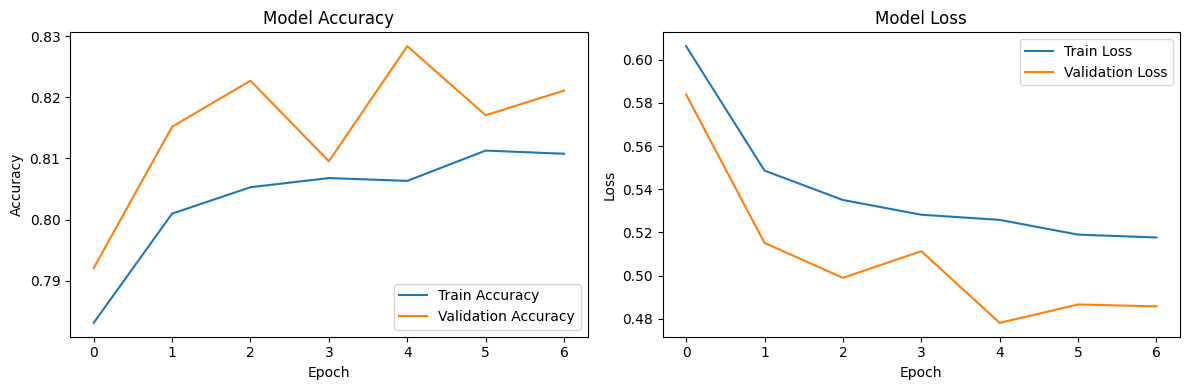

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Load Data
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

# Define constants
MAX_LENGTH = 164
BATCH_SIZE = 4
EPOCHS = 10
NUM_LABELS = 3

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize the data
def tokenize_data(texts, tokenizer, max_length):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Tokenize inputs
train_encodings = tokenize_data(train_df['tweet'], tokenizer, MAX_LENGTH)
val_encodings = tokenize_data(val_df['tweet'], tokenizer, MAX_LENGTH)
test_encodings = tokenize_data(test_df['tweet'], tokenizer, MAX_LENGTH)

# Labels
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

# Prepare datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(len(train_df)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(BATCH_SIZE)

# Load the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_LABELS)

# Freeze all layers except the classification layer
for layer in model.layers[:-1]:
    layer.trainable = False


model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model', save_best_only=True, save_weights_only=True, save_format='tf')  # Changed save_format
]


# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


930/930 [==============================] - 59s 63ms/step - loss: 0.4759 - accuracy: 0.8254
Test Loss: 0.4758569598197937
Test Accuracy: 0.8254438042640686
930/930 [==============================] - 66s 62ms/step


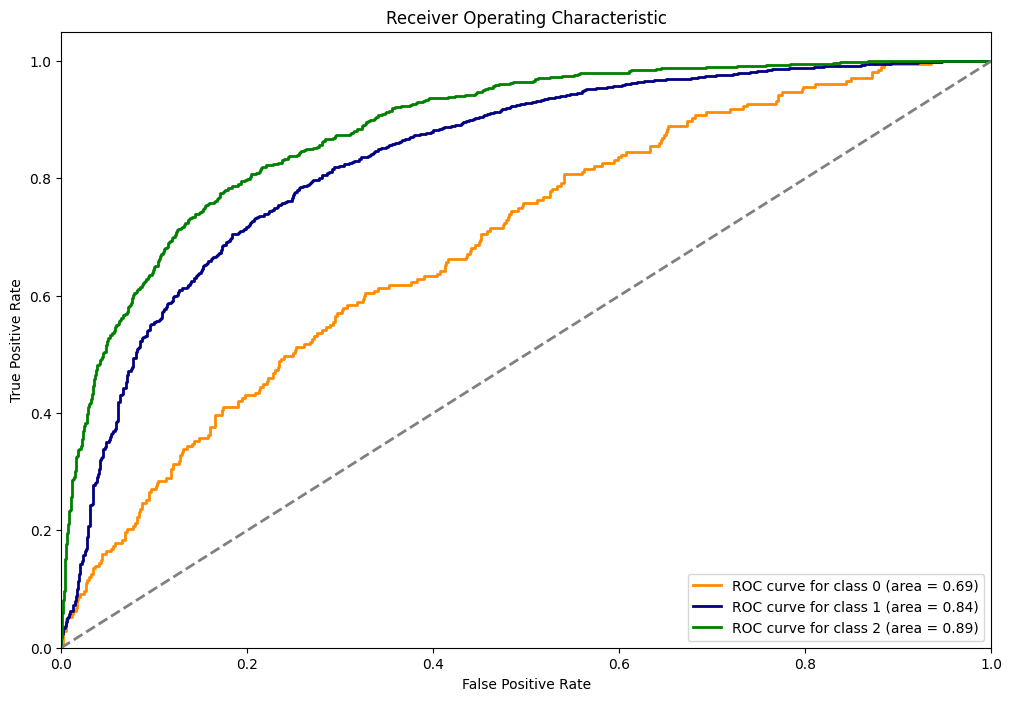

Precision: 0.7991681264895328
Recall: 0.8254437869822485
F1 Score: 0.7951870107406472
Confusion Matrix:
[[   3  178   26]
 [   3 2747  130]
 [   0  312  319]]


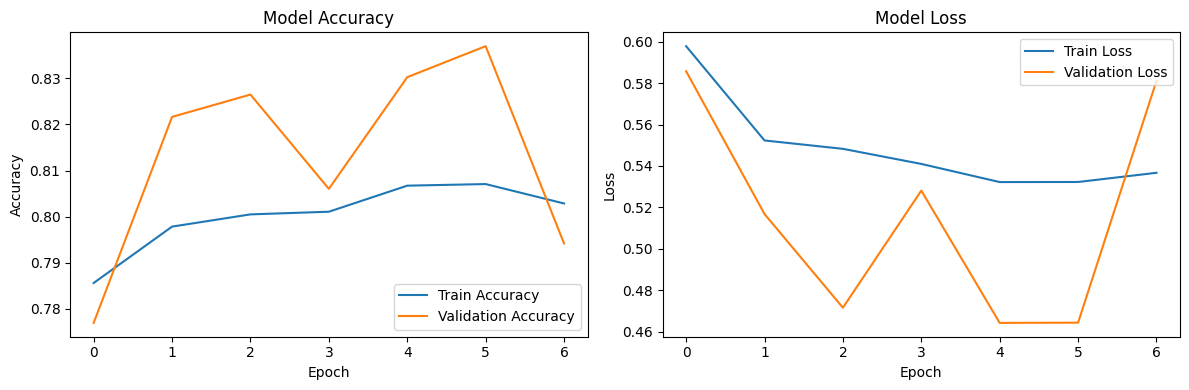

In [ ]:
# Load the best weights
model.load_weights('best_model')

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict on test data
predictions = model.predict(test_dataset).logits
predicted_labels = np.argmax(predictions, axis=1)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(NUM_LABELS):
    fpr[i], tpr[i], _ = roc_curve(test_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(12, 8))
colors = ['darkorange', 'navy', 'green']
for i in range(NUM_LABELS):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Print confusion matrix as a table with labels
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=['True: 0 - Hate Speech', 'True: 1 - Offensive Language', 'True: 2 - Neither'],
                              columns=['Predicted: 0 - Hate Speech', 'Predicted: 1 - Offensive Language', 'Predicted: 2 - Neither'])

print("Confusion Matrix:")
conf_matrix_df

Confusion Matrix:


,Predicted: 0 - Hate Speech,Predicted: 1 - Offensive Language,Predicted: 2 - Neither
True: 0 - Hate Speech,3,178,26
True: 1 - Offensive Language,3,2747,130
True: 2 - Neither,0,312,319


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 2307 (9.01 KB)
Non-trainable params: 109482240 (417.64 MB)
_________________________________________________________________


## using class wieghts to deal with imbalanced distribution

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
272/272 [==============================] - 465s 2s/step - loss: 0.6366 - accuracy: 0.7780 - val_loss: 0.5730 - val_accuracy: 0.7910
Epoch 2/10
272/272 [==============================] - 427s 2s/step - loss: 0.5786 - accuracy: 0.7917 - val_loss: 0.5390 - val_accuracy: 0.8044
Epoch 3/10
272/272 [==============================] - 423s 2s/step - loss: 0.5566 - accuracy: 0.8018 - val_loss: 0.5325 - val_accuracy: 0.7985
Epoch 4/10
272/272 [==============================] - 431s 2s/step - loss: 0.5480 - accuracy: 0.8079 - val_loss: 0.5122 - val_accuracy: 0.8106
Epoch 5/10
272/272 [==============================] - 421s 2s/step - loss: 0.5367 - accuracy: 0.8064 - val_loss: 0.5010 - val_accuracy: 0.8168
Epoch 6/10
272/272 [==============================] - 409s 2s/step - loss: 0.5345 - accuracy: 0.8072 - val_loss: 0.5100 - val_accuracy: 0.8179
Epoch 7/10
272/272 [==============================] - 428s 2s/step - loss: 0.5318 - accuracy: 0.8061 - val_loss: 0.5008 - val_accuracy: 0.8238

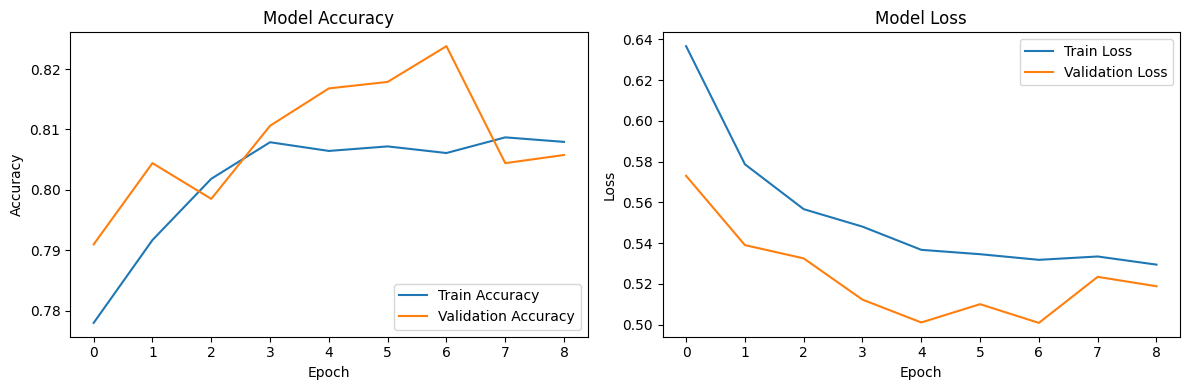

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define constants
MAX_LENGTH = 256
BATCH_SIZE = 64
EPOCHS = 10
NUM_LABELS = 3
LEARNING_RATE = 2e-5

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize the data
def tokenize_data(texts, tokenizer, max_length):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Tokenize inputs
train_encodings = tokenize_data(train_df['tweet'], tokenizer, MAX_LENGTH)
val_encodings = tokenize_data(val_df['tweet'], tokenizer, MAX_LENGTH)
test_encodings = tokenize_data(test_df['tweet'], tokenizer, MAX_LENGTH)

# Labels
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: class_weights[i] for i in range(NUM_LABELS)}

# Prepare datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(len(train_df)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(BATCH_SIZE)

# Load the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_LABELS)

# Freeze all layers except the classification layer
for layer in model.layers[:-1]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model', save_best_only=True, save_weights_only=True, save_format='tf')
]

# Train the model with class weights
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights_dict  # Include class weights here
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()



59/59 [==============================] - 69s 1s/step - loss: 0.5089 - accuracy: 0.8238
Test Loss: 0.5089060664176941
Test Accuracy: 0.8238300085067749
59/59 [==============================] - 78s 1s/step


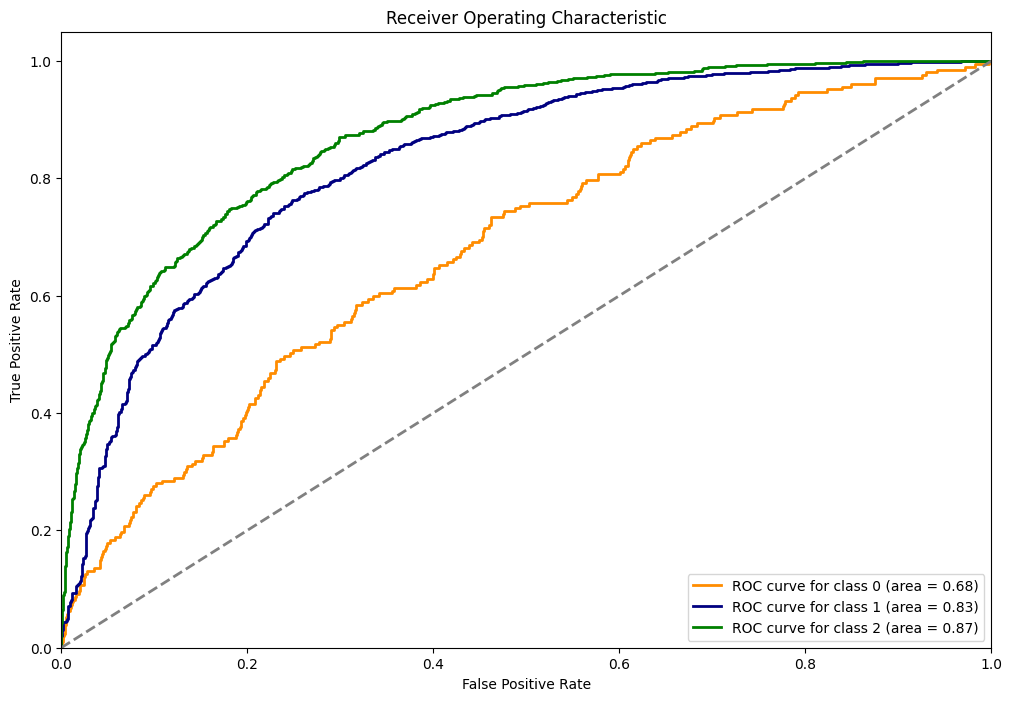

Precision: 0.7881592439937526
Recall: 0.8238300161377085
F1 Score: 0.792543966865805
Confusion Matrix:
[[   2  181   24]
 [   2 2751  127]
 [   2  319  310]]


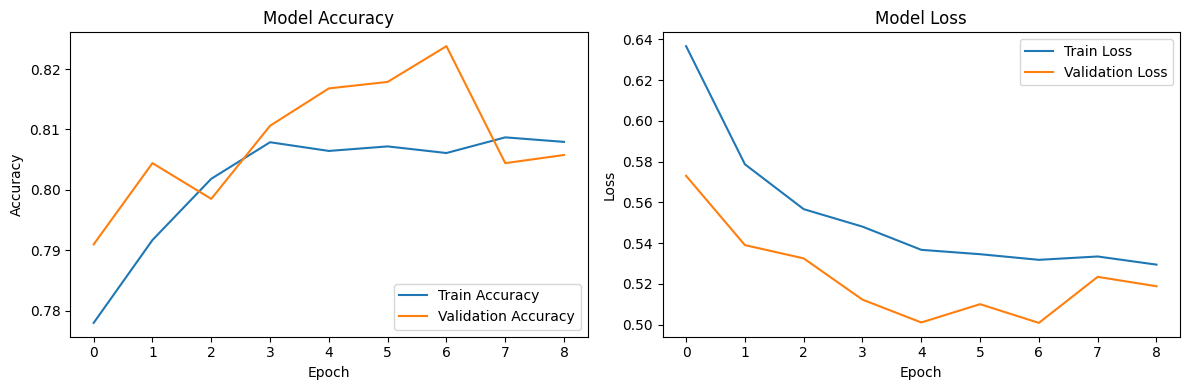

In [ ]:
# Load the best weights
model.load_weights('best_model')

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict on test data
predictions = model.predict(test_dataset).logits
predicted_labels = np.argmax(predictions, axis=1)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(NUM_LABELS):
    fpr[i], tpr[i], _ = roc_curve(test_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(12, 8))
colors = ['darkorange', 'navy', 'green']
for i in range(NUM_LABELS):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# Print confusion matrix as a table with labels
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=['True: 0 - Hate Speech', 'True: 1 - Offensive Language', 'True: 2 - Neither'],
                              columns=['Predicted: 0 - Hate Speech', 'Predicted: 1 - Offensive Language', 'Predicted: 2 - Neither'])

print("Confusion Matrix:")
conf_matrix_df

Confusion Matrix:


,Predicted: 0 - Hate Speech,Predicted: 1 - Offensive Language,Predicted: 2 - Neither
True: 0 - Hate Speech,2,181,24
True: 1 - Offensive Language,2,2751,127
True: 2 - Neither,2,319,310


## roberta weighted

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define constants
MAX_LENGTH = 256
BATCH_SIZE = 64
EPOCHS = 10
NUM_LABELS = 3
LEARNING_RATE = 2e-5
model_name = 'roberta-large'

# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Function to tokenize the data
def tokenize_data(texts, tokenizer, max_length):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Tokenize inputs
train_encodings = tokenize_data(train_df['tweet'], tokenizer, MAX_LENGTH)
val_encodings = tokenize_data(val_df['tweet'], tokenizer, MAX_LENGTH)
test_encodings = tokenize_data(test_df['tweet'], tokenizer, MAX_LENGTH)

# Labels
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: class_weights[i] for i in range(NUM_LABELS)}

# Prepare datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(len(train_df)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(BATCH_SIZE)

# Load the model
model = TFRobertaForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS)

# Freeze all layers except the classification layer
for layer in model.layers[:-1]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model', save_best_only=True, save_weights_only=True, save_format='tf')
]

# Train the model with class weights
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights_dict  # Include class weights here
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
# Load the best weights
model.load_weights('best_model')

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict on test data
predictions = model.predict(test_dataset).logits
predicted_labels = np.argmax(predictions, axis=1)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(NUM_LABELS):
    fpr[i], tpr[i], _ = roc_curve(test_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(12, 8))
colors = ['darkorange', 'navy', 'green']
for i in range(NUM_LABELS):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Print confusion matrix as a table with labels
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index=['True: 0 - Hate Speech', 'True: 1 - Offensive Language', 'True: 2 - Neither'],
                              columns=['Predicted: 0 - Hate Speech', 'Predicted: 1 - Offensive Language', 'Predicted: 2 - Neither'])

print("Confusion Matrix:")
conf_matrix_df